In [1]:
import os
import shutil
import glob
import logging
import random
from pathlib import Path
from time import time

import cv2
import PIL.Image as Image
#from sklearn.preprocessing import PowerTransformer
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torchvision.models import resnet152
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
#from fastai.vision.models import DynamicUnet
#import holocron.models as models  # For UNet++ and UNet+++
sns.set_style("darkgrid")


''

In [12]:
def get_image_metadata(path_to_file):
    """Function for extracting metadata from filename of dataset provided by AstraZeneca.
    
    B02   - well (row B, column 02) 
    T0001 - timepoint (irrelevant for this dataset) 
    F001  - field of view = site 
    L01   - timeline (irrelevant for this datset) 
    A01   - action list number (3 fluorescent + 1 brightfield action) 
    Z01   - 3D z-number (slice number or vertical position) 
    C01   - imaging channel (1 nuclear, 2 lipids, 3 cytoplasm, 4 brightfield)
    """
    string_arr = os.path.basename(path_to_file).split("_")
    row_col = string_arr[-2] # Row and column
    timepoint = string_arr[-1][:5]
    fied_of_view = string_arr[-1][5:9]
    timeline = string_arr[-1][9:12]
    action_list_number = string_arr[-1][12:15]
    z_number_3d = string_arr[-1][15:18]
    imaging_channel = string_arr[-1][18:21]
    return {
        "row_col":       row_col,
        #"timepoint":     timepoint,  # apparently irrelevant
        "field of view": fied_of_view,
        #"timeline": timeline,  # apparently irrelevant
        "action_list_number": action_list_number,
        "z_number_3d": z_number_3d,
        "imaging_channel": imaging_channel,
        "path": path_to_file
    }

class ExampleSegmentationDataset(Dataset):

    def __init__(self, dataset_path, crop_size=(256,256), transform=None, train=True):
        """Example dataset for sample images for the Astra Zeneca competition
        
        Group by row_col and field of view
        # row_col
        # field of view
         
        Input and Target share these common values:
        - row_col       = sample id? 
        - field of view = amount of zoom

        For identifying INPUT:
        - action_list_number A04
        - imaging_channel    C04
        - z_number_3d        Z01 - Z07

        For identifying TARGET:
        - action_list_number A01 A02 and A03
        - imaging_channel    C01, C02, C03
        - z_number_3d        Z01
        """
        self.dataset_path = dataset_path
        
        dataset_samples = glob.glob(os.path.join(self.dataset_path, "*/*/Assay*"))
        if len(dataset_samples) == 0: # Bad solution 
            dataset_samples = glob.glob(os.path.join(self.dataset_path, "*/Assay*"))

        dataset_dicts = [get_image_metadata(path) for path in dataset_samples]
        
        # Group all 7 inputs with all 3 respective targets into variable sample
        samples = dict()
        for sample_dict in dataset_dicts:
            sample_key = (sample_dict["row_col"], sample_dict["field of view"])

            if samples.get(sample_key) is None:
                samples[sample_key] = {
                    "input": dict(),
                    #"target": dict(),
                    "masks": dict()
                }

            if sample_dict["action_list_number"] == "A04": # or sample_dict["imaging_channel"] == "C04"
                # Is an input
                z_number_3d = sample_dict["z_number_3d"]
                samples[sample_key]["input"][z_number_3d] = sample_dict["path"]
            else:
                # Is an target
                if "masks" in sample_dict["path"]:
                    action_list_number = sample_dict["action_list_number"]
                    samples[sample_key]["masks"][action_list_number] = sample_dict["path"]
                #else:
                #    action_list_number = sample_dict["action_list_number"]
                #    samples[sample_key]["target"][action_list_number] = sample_dict["path"]
                
        self.samples = list(samples.values())
        self.crop_size = crop_size
        self.transforms = transform
        self.train = train
        
    def __len__(self):
        return 200

    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Modulo
        idx = idx % len(self.samples)

        sample_dict = self.samples[idx]

        w, h = cv2.imread(sample_dict["input"]["Z01"], -1).shape
        assert self.crop_size[0] <= w
        assert self.crop_size[1] <= h

        input = np.zeros((w, h, 7), dtype=np.float32)
        for i, z_number_3d in enumerate(["Z01", "Z02", "Z03", "Z04", "Z05", "Z06", "Z07"]):
            img_path = sample_dict["input"][z_number_3d]
            img = cv2.imread(img_path, -1)
            input[:,:,i] = img
        
        mask_output = np.zeros((w, h), dtype=np.float32)
        img_path = sample_dict["masks"]["A01"]
        mask_output = cv2.imread(img_path, -1)
        mask_output = mask_output.astype(np.float32)
        
        data = {
            "image": input,
            "mask": mask_output
        }
        if self.transforms:
            for transform in self.transforms:
                data = transform(image=data["image"], mask=data["mask"])
        
        return data["image"], data["mask"]


In [13]:
class UNet(nn.Module):
    """Just a basic UNet model.

    https://github.com/milesial/Pytorch-UNet
    """
    def __init__(self, input_channels=7, output_channels=3):
        super(UNet, self).__init__()

        # Get model from PyTorch hub
        net = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana')

        # Configure input layer to take 7 channels
        net.inc.double_conv[0] = nn.Conv2d(
            input_channels, 
            net.inc.double_conv[0].out_channels, 
            kernel_size = net.inc.double_conv[0].kernel_size, 
            stride = net.inc.double_conv[0].stride, 
            padding = net.inc.double_conv[0].padding
            )

        # Configure output layer to output 3 channels
        net.outc.conv = nn.Conv2d(
            net.outc.conv.in_channels,
            output_channels,
            kernel_size = net.outc.conv.kernel_size,
            stride = net.outc.conv.stride
        )
        self.net = net
    
    def forward(self, x):
        return self.net(x)
    
model = UNet(input_channels=7, output_channels=1)

Using cache found in C:\Users\Succe/.cache\torch\hub\milesial_Pytorch-UNet_master


In [14]:
checkpoint = torch.load("../weights/model_35.pth")

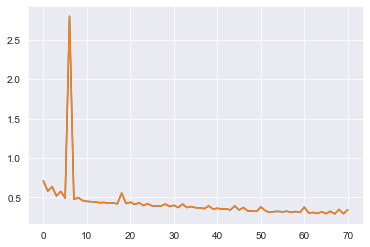

In [15]:
plt.figure()
plt.plot(checkpoint["train_losses"])
plt.plot(checkpoint["valid_losses"])
plt.show()

In [16]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [18]:
valid_transforms = A.Compose([
    A.RandomCrop(256,256),
    ToTensorV2()
])


valid_dataset = ExampleSegmentationDataset("../data/03_train_valid/valid/", transform=valid_transforms, train=False)

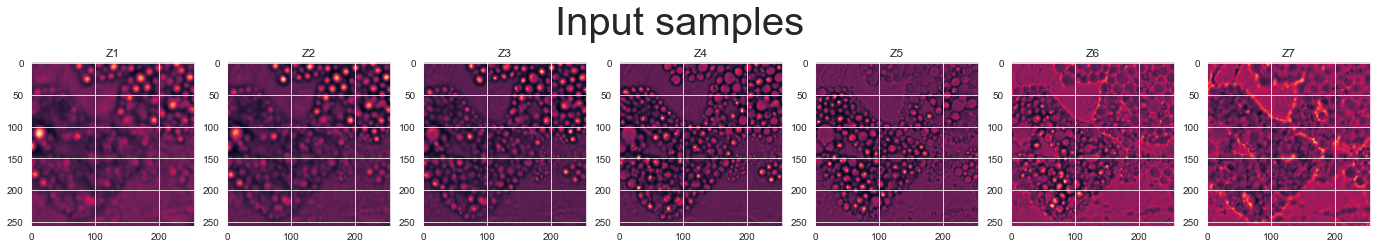

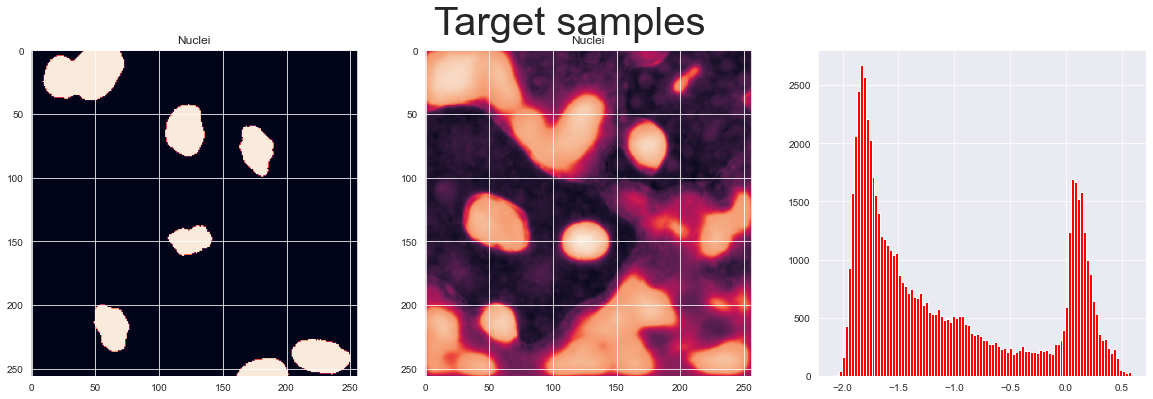

In [43]:
# Sample inference and visualization
x, y = valid_dataset[3]
fig, ax = plt.subplots(1,7, figsize=(24,4))
fig.suptitle("Input samples", fontsize=40)
names = ["Z1", "Z2", "Z3", "Z4", "Z5", "Z6", "Z7"]
for i, x_sample in enumerate(x):
    ax[i].set_title(names[i])
    ax[i].imshow(x_sample)

fig, ax = plt.subplots(1, 3, figsize=(20,6))

fig.suptitle("Target samples", fontsize=40)
ax[0].set_title("Nuclei")
ax[0].imshow(y)

model.eval()
with torch.no_grad():
    preds = model(x.unsqueeze(0).to(device)).cpu()

    pred = preds[0,0].detach().numpy()
    
    ax[1].set_title("Nuclei")
    ax[1].imshow(pred)
    
    ax[2].hist(pred.flatten(), color="r", bins=100)
plt.show()
